<a href="https://colab.research.google.com/github/fringwald/CNN/blob/master/hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktische Übung Hyperparameter

In this notebook you can execute code snippets to get an understanding of how hyperparameter work.

To execute the notebook click in the header above:

 Laufzeit -> alle ausführen

Remember to wait until you see the graphs at the bottom to ensure all blocks got executed. Training takes time.

Excercises:



1.   Change hyperparameters like learning rate, e.g. 0.00001, 0.1

      Remember to execute the notebook again after each change as described above
2.   Check performance of network at the bottom and try to find an optimal learning rate

In [28]:
#@title Imports and loading the data
#doing all the necessary imports
import torch
import torchvision
import torchvision.transforms as transforms
from  torchvision import models
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#title Loading the CIFAR10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


  car  deer  ship  ship


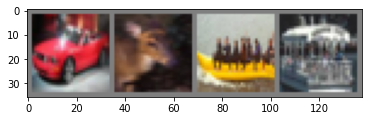

In [29]:
#@title Visualizing some images and their labels
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [30]:
#@title Defining network structure
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


network = Net()

In [31]:
#@title  _
#setting up some variables to store information while training
train_losses = []
train_acc =[]
train_counter = []
test_losses = []
epoch_loss = []
val_loss = []
val_acc = []

In [32]:
#@title Change Hyperparameters here
#Setting up hpyerparameters
n_epoch = 2
learning_rate = 0.001 #changing learning rate 0.001, 0.00001, 0.1


In [33]:
#@title Definition of training function and executing training 
#setting up optimizer and criterion
import torch.optim as optim
momentum = 0.9
best_acc = 0.0

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

#defining train function
def train(n_epoch):
  print('Start epoch %s/%s training..' %(epoch, n_epoch))
  epoch_count = []
  network.train()
  running_loss = 0.0
  running_corrects = 0
  for batch_idx, (inputs, labels) in enumerate(trainloader):
    optimizer.zero_grad()
    with torch.set_grad_enabled(True):
      prediction = network(inputs)
      _, preds = torch.max(prediction, 1)
      loss = criterion(prediction, labels)
      loss.backward()
      optimizer.step()
    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
  epoch_loss = running_loss / len(trainloader.dataset)
  train_losses.append(epoch_loss)
  epoch_acc = float(running_corrects.double() / len(trainloader.dataset))
  train_acc.append(epoch_acc)
  epoch_count.append(n_epoch +1)
  print('Epoch: {} Loss: {:.4f}  Accuracy: {:.4f}'.format(epoch_count, epoch_loss, epoch_acc))

#calling training function
for epoch in range (0, n_epoch):
  train(epoch)

Start epoch 0/0 training..
Epoch: [1] Loss: 1.7368  Accuracy: 0.3616
Start epoch 1/1 training..
Epoch: [2] Loss: 1.3509  Accuracy: 0.5145



GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


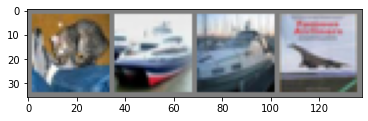

In [34]:
#@title How does our network perform on some test images?
#visualizing images
print('')
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

#What are predictions of net on images above
#testing network on images above
outputs = network(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))



In [35]:
#@title Definition of test function and evaluation
#test function to test images against trained network
def test():
  correct = 0
  total = 0
  acc0 = []
  prec0 = []
  sens0 = []
  spec0 = []
  fscore0 =[]
  acc1 = []
  prec1 = []
  sens1 = []
  spec1 = []
  fscore1 =[]
  with torch.no_grad():
    for data in testloader:
      images, labels = data
      outputs = network(images)
      _, preds = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (preds == labels). sum().item()

      nb_classes = len(testset.classes)
      conf_matrix = torch.zeros(nb_classes, nb_classes)
      for l,p in zip(labels, preds):
        conf_matrix[l,p] +=1
      #print(conf_matrix)
      TP = conf_matrix.diag()
      for c in range(nb_classes):
        idx = torch.ones(nb_classes).byte()
        idx[c] = 0
        #all non-class samples classified as non-class
        TN = conf_matrix[idx.nonzero()[:, None], idx.nonzero()].sum ()
        # all non-class samples classified as class
        FP = conf_matrix [idx, c].sum()
        #all class samples not classified as class
        FN = conf_matrix[c, idx].sum()
        
        sensitivity = round(float(TP[c]/(TP[c]+FN))*100, 2)
        specificity = round(float(TN/(TN+FP))*100, 2)
        accuracy = round(float((TP[c]+TN)/(TN+TP[c]+FN+FP))*100, 2)
        precision = round(float(TP[c]/(TP[c]+FP))*100, 2)
        fscore = round(float((2*TP[c])/((2*TP[c])+FP+FN)) * 100, 2)

        if c == 0:
            acc0.append(accuracy)
            prec0.append(precision)
            sens0.append(sensitivity)
            spec0.append(specificity)
            fscore0.append(fscore)
        if c == 1:
            acc1.append(accuracy)
            prec1.append(precision)
            sens1.append(sensitivity)
            spec1.append(specificity)
            fscore1.append(fscore)
            
  print('Performance report of Class 0:')
  print('Accuracy of class 0',' is', np.nanmean(acc0))
  print('Precision of class 0',' is', np.nanmean(prec0))
  print('Sensitivity of class 0',' is', np.nanmean(sens0)) 
  print('Specificity of class 0',' is', np.nanmean(spec0))
  print('F-Score of class 0',' is', np.nanmean(fscore0))
  print(' ')
  print('Performance report of Class 1:')
  print('Accuracy of class 1',' is', np.nanmean(acc1))
  print('Precision of class 1',' is', np.nanmean(prec1))
  print('Sensitivity of class 1',' is', np.nanmean(sens1)) 
  print('Specificity of class 1',' is', np.nanmean(spec1))
  print('F-Score of class 1',' is', np.nanmean(fscore1))

  print('Overall performance')
  print('')
  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))



test()

      


Performance report of Class 0:
Accuracy of class 0  is 92.33
Precision of class 0  is 61.799582822085895
Sensitivity of class 0  is 58.73295906432749
Specificity of class 0  is 95.94344
F-Score of class 0  is 44.94108477666364
 
Performance report of Class 1:
Accuracy of class 1  is 93.86
Precision of class 1  is 81.25372549019608
Sensitivity of class 1  is 50.67988344988345
Specificity of class 1  is 98.6728531412565
F-Score of class 1  is 47.06751072961374
Overall performance

Accuracy of the network on the 10000 test images: 53 %


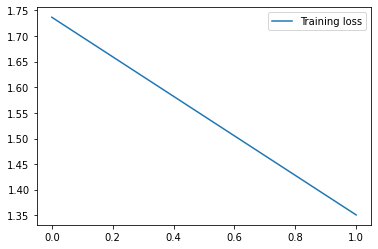

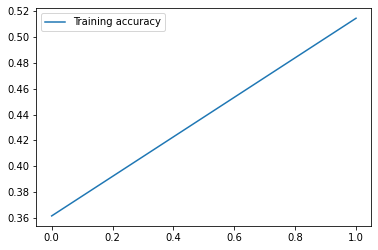

In [36]:
#@title Plotting training loss and training accuracy
#plotting loss and accuracy
plt.plot(train_losses, label = 'Training loss')
plt.legend()
plt.show()
plt.plot(train_acc, label = 'Training accuracy')
plt.legend()
plt.show()